Load modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train_raw = pd.read_csv('train.csv')

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Check missing values

In [3]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
train_raw.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
print([(colname, sum(features[colname].isnull())) for colname in features.columns])
print([(colname, sum(stores[colname].isnull())) for colname in stores.columns])
print([(colname, sum(train_raw[colname].isnull())) for colname in train_raw.columns])

[('Store', 0), ('Date', 0), ('Temperature', 0), ('Fuel_Price', 0), ('MarkDown1', 4158), ('MarkDown2', 5269), ('MarkDown3', 4577), ('MarkDown4', 4726), ('MarkDown5', 4140), ('CPI', 585), ('Unemployment', 585), ('IsHoliday', 0)]
[('Store', 0), ('Type', 0), ('Size', 0)]
[('Store', 0), ('Dept', 0), ('Date', 0), ('Weekly_Sales', 0), ('IsHoliday', 0)]


Change column format to datetime

In [7]:
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
features['Date'] = pd.to_datetime(features['Date'])

Merge dataframes

In [8]:
merged_1 = pd.merge(train_raw, stores, how = 'left', on = 'Store')
merged = pd.merge(merged_1, features, how = 'left', on = ['Store', 'Date'])
merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Get only departments with full date range

In [9]:
merged['counts'] = merged.groupby(['Store', 'Dept'])['Date'].transform(lambda x: len(x.unique()))
df_full = merged[merged['counts'] == 143]

Aggregate to get sales by date

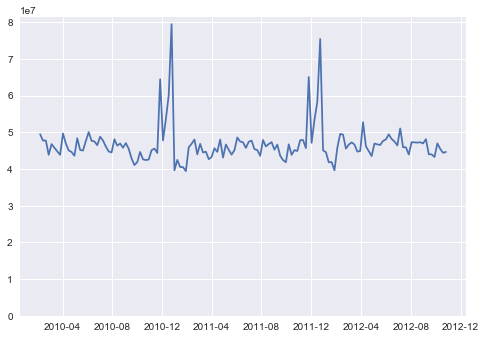

In [10]:
agg = df_full.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.plot(agg['Date'], agg['Weekly_Sales']) 
plt.ylim(ymin = 0)
plt.show()

Seasonal spikes and cyclic patterns, need to normalise and differenced for ARIMA

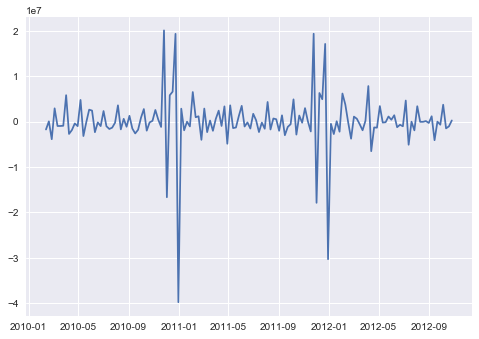

In [11]:
agg['Weekly_Sales_1d'] = agg['Weekly_Sales'].diff(1)
plt.plot(agg['Date'], agg['Weekly_Sales_1d']) 
plt.show()

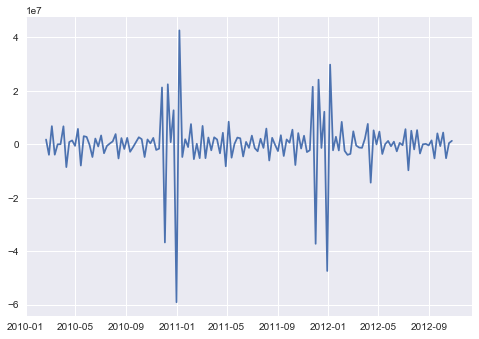

In [12]:
agg['Weekly_Sales_2d'] = agg['Weekly_Sales_1d'].diff(1)
plt.plot(agg['Date'], agg['Weekly_Sales_2d']) 
plt.show()

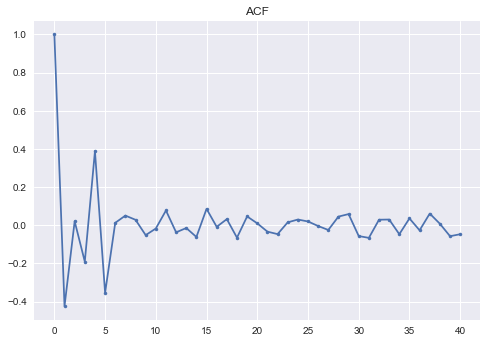

In [29]:
acf_ = acf(agg['Weekly_Sales_1d'].iloc[1:])
plt.plot(acf_, marker = '.')
plt.title('ACF')
plt.show()

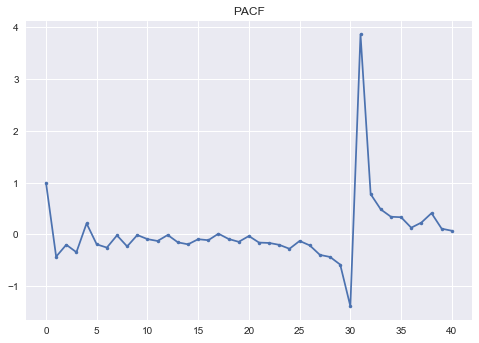

In [14]:
pacf_ = pacf(agg['Weekly_Sales_1d'].iloc[1:])
plt.plot(pacf_, marker = '.')
plt.title('PACF')
plt.show()

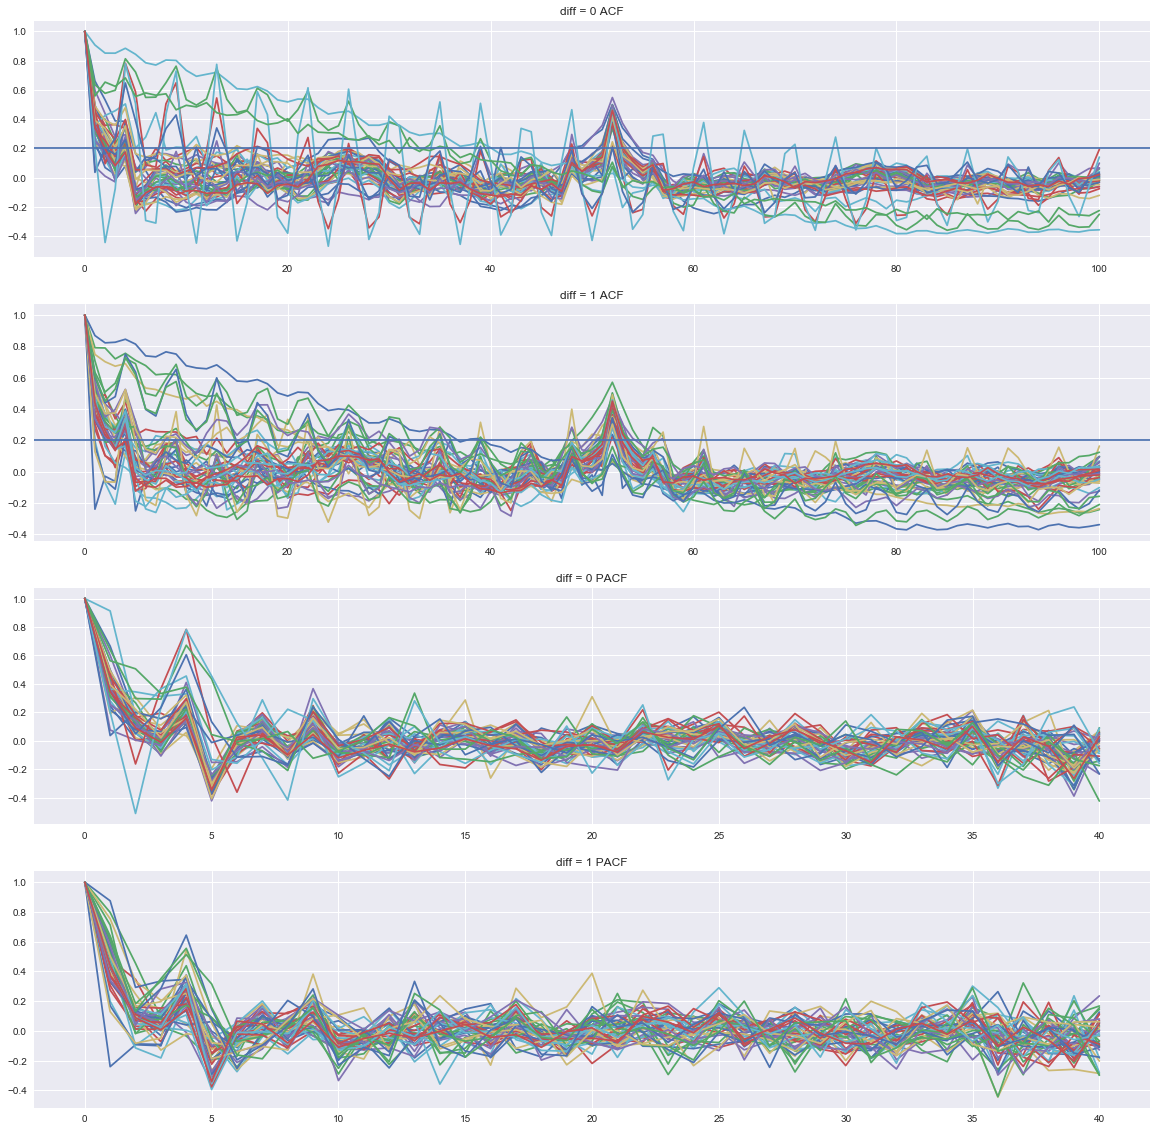

In [61]:
agg_store = df_full.groupby(['Date', 'Store'])['Weekly_Sales'].sum().reset_index()
agg_store['Weekly_Sales_1d'] = agg_store['Weekly_Sales'].diff(1)

f1, ax = plt.subplots(4, 1, figsize = (20, 20))

for s in agg_store['Store'].unique():
#for s in range(1, 20, 1):
    agg_temp = agg_store.loc[agg_store['Store'] == s, :]

    ax[0].plot(acf(agg_temp['Weekly_Sales'].iloc[1:], nlags=100))
    ax[1].plot(acf(agg_temp['Weekly_Sales_1d'].iloc[1:], nlags=100))
    ax[2].plot(pacf(agg_temp['Weekly_Sales'].iloc[1:]))
    ax[3].plot(pacf(agg_temp['Weekly_Sales_1d'].iloc[1:]))

ax[0].set_title('diff = 0 ACF') 
ax[1].set_title('diff = 1 ACF')
ax[2].set_title('diff = 0 PACF')
ax[3].set_title('diff = 1 PACF')

ax[0].axhline(0.2)
ax[1].axhline(0.2)

plt.show()

ACF shows strong influence of recent movements but PACF suggests monthly, annually pattern but no quarter, try ARIMA

freq = 4 weeks


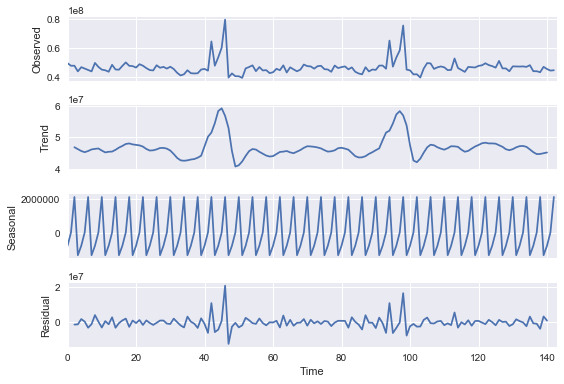

In [16]:
decomposition = seasonal_decompose(agg['Weekly_Sales'].tolist(), freq = 4)  
decomp = decomposition.plot()
print('freq = 4 weeks')
plt.show()

Set frequency to 4 weeks (1 month) and the season pattern is very clear, no discernible overall trend is shown though.

freq = 13 weeks


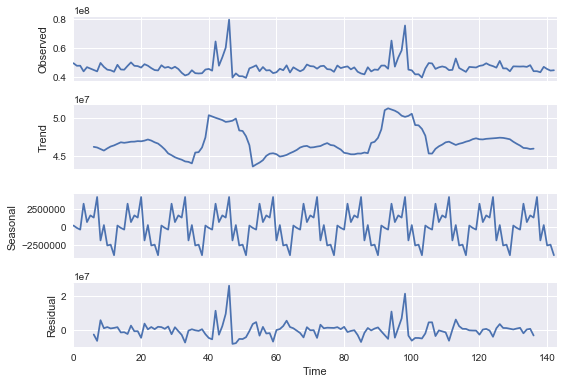

In [17]:
decomposition2 = seasonal_decompose(agg['Weekly_Sales'].tolist(), freq = 13)  
decomp2 = decomposition2.plot()
print('freq = 13 weeks')
plt.show()

Decomposition by quarter also also shows interesting seasonal trend but requires larger residuals.

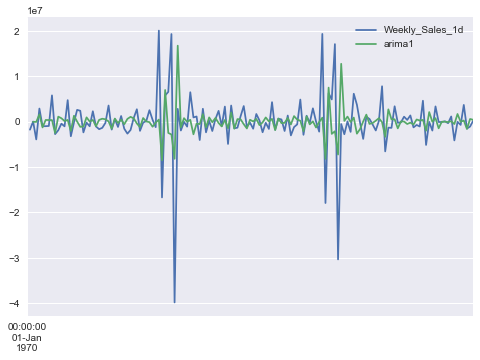

In [18]:
agg.set_index('Date')
agg.index = pd.to_datetime(agg.index)
model_1d = sm.tsa.ARIMA(agg['Weekly_Sales'].iloc[1:], order=(1, 1, 0))  
results = model_1d.fit(disp=-1)  
agg['arima1'] = results.fittedvalues  
agg[['Weekly_Sales_1d', 'arima1']].plot()
plt.show()

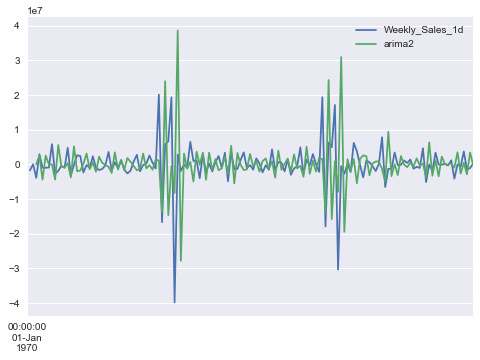

In [19]:
model_2d = sm.tsa.ARIMA(agg['Weekly_Sales'].iloc[1:], order=(1, 2, 0))  
results = model_2d.fit(disp=-1)  
agg['arima2'] = results.fittedvalues  
agg[['Weekly_Sales_1d', 'arima2']].plot()
plt.show()

Both 1d and 2d differencing give quite inaccurate predictions. ARIMA may not be that useful after all.

Disaggregate by year

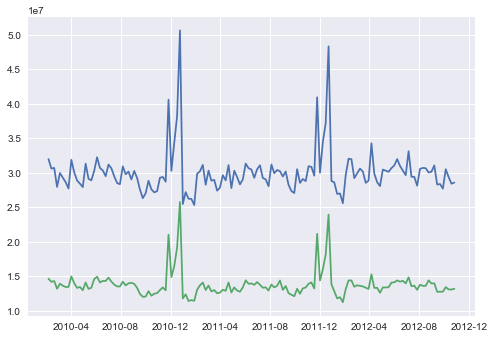

In [20]:
df_full.loc[:, 'year'] = df_full['Date'].dt.year
agg2_ = df_full.groupby(['Type', 'Date'])['Weekly_Sales'].sum().reset_index()
agg2_
for i in ['A', 'B']:
    plt.plot(agg2_['Date'][agg2_['Type'] == i], agg2_['Weekly_Sales'][agg2_['Type'] == i], label = i)
plt.show()

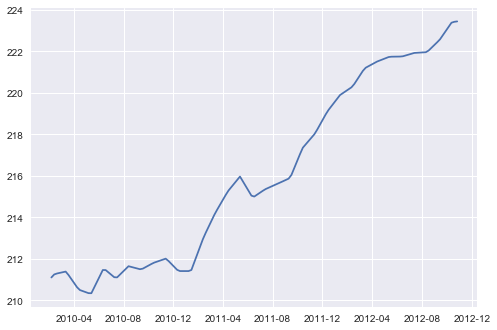

In [21]:
agg3_ = df_full.groupby('Date')['CPI'].agg(lambda x: x.unique()[0])
plt.plot(agg3_)
plt.show()

Don't think CPI has anything to do with sales, purchasing power going down?

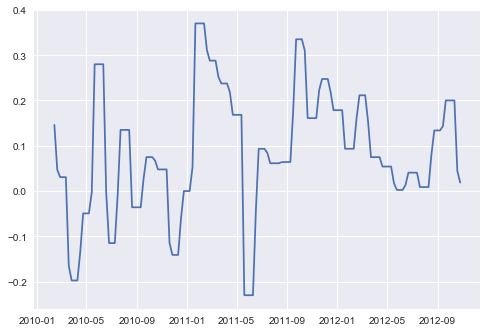

In [22]:
df_full['CPI_1d'] = df_full['CPI'].diff(1)
agg4_ = df_full.groupby('Date')['CPI_1d'].agg(lambda x: x.unique()[0])
plt.plot(agg4_)
plt.show()

Not quite stationary enough yet, need to go deeper.

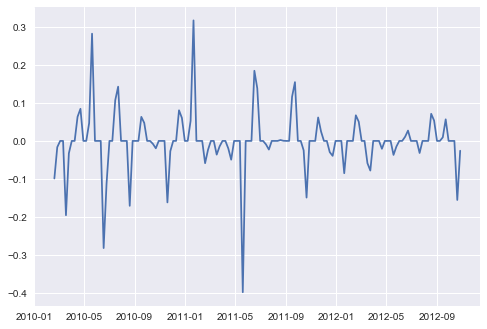

In [23]:
df_full['CPI_2d'] = df_full['CPI_1d'].diff(1)
agg5_ = df_full.groupby('Date')['CPI_2d'].agg(lambda x: x.unique()[0])
plt.plot(agg5_)
plt.show()

Looks good but try go deeper.